# 深度神经网络

## 多层感知机

略

## 多层感知机从零开始实现

我们将继续使用Fashion-MNIST 图像分类数据集

In [1]:
import torch
from torch import nn
from d2l import torch as d2l
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
print(f"每一批{len(next(iter(train_iter))[0])}个，一共{len(train_iter)}批")

每一批256个，一共235批


### 初始化模型参数

Fashion-MNIST 中的每个图像由28 × 28 = 784 个灰度像素值组成。所有图像共分为10 个类别。忽略像素之
间的空间结构，我们可以将每个图像视为具有784 个输入特征和10 个类的简单分类数据集。首先，我们将实现
一个具有单隐藏层的多层感知机，它包含256 个隐藏单元。注意，我们可以将这两个变量都视为超参数。通常，
我们选择2 的若干次幂作为层的宽度。因为内存在硬件中的分配和寻址方式，这么做往往可以在计算上更高效。

我们用几个张量来表示我们的参数。注意，对于每一层我们都要记录一个权重矩阵和一个偏置向量。跟以
前一样，我们要为损失关于这些参数的梯度分配内存。

In [9]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256
W1 = nn.Parameter(torch.randn(
num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(
num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

### 激活函数

In [10]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

### 模型

因为我们忽略了空间结构，所以我们使用reshape 将每个二维图像转换为一个长度为num_inputs 的向量。只
需几行代码就可以实现我们的模型。

In [11]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1) # 这里“@”代表矩阵乘法
    return (H@W2 + b2)

### 损失函数

在这里我们直接使用高级API 中的内置函数来计算softmax 和交叉熵损失。

In [12]:
loss = nn.CrossEntropyLoss(reduction='none')

### 训练

多层感知机的训练过程与softmax 回归的训练过程完全相同。可以直接调用d2l 包的train_ch3 函数，将迭代
周期数设置为10，并将学习率设置为0.1.

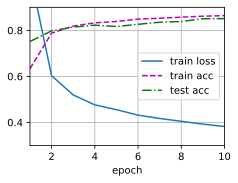

In [13]:
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

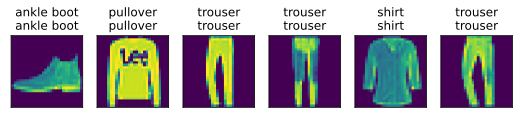

In [14]:
d2l.predict_ch3(net, test_iter)

## 多层感知机的简洁实现

本节将介绍通过高级API 更简洁地实现多层感知机。

In [15]:
import torch
from torch import nn
from d2l import torch as d2l

### 模型

与softmax 回归的简洁实现相比，唯一的区别是我们添加了2 个全连接层（之前我们只添加了1 个全连接
层）。第一层是隐藏层，它包含256 个隐藏单元，并使用了ReLU 激活函数。第二层是输出层。

In [16]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 256), nn.ReLU(), nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
net.apply(init_weights);

训练过程的实现与我们实现softmax 回归时完全相同，这种模块化设计使我们能够将与模型架构有关的内容独
立出来。

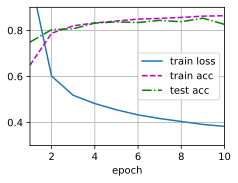

In [17]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 层和块

事实证明，研究讨论“比单个层大”但“比整个模型小”的组件更有价值。例如，在计算机视觉中广泛流行
的ResNet-152 架构就有数百层，这些层是由层组（groups of layers）的重复模式组成。这个ResNet 架构赢得了2015 年ImageNet 和COCO 计算机视觉比赛的识别和检测任务。目前ResNet 架构仍然是许多视觉任务的首选架构。在其他的领域，如自然语言处理和语音，层组以各种重复模式排列的类似架构现在也是普遍存在。

为了实现这些复杂的网络，我们引入了神经网络块的概念。块（block）可以描述单个层、由多个层组成的
组件或整个模型本身。使用块进行抽象的一个好处是可以将一些块组合成更大的组件，这一过程通常是递归的，如图1.2所示。通过定义代码来按需生成任意复杂度的块，我们可以通过简洁的代码实现复杂的神经网络。

从编程的角度来看，块由类（class）表示。它的任何子类都必须定义一个将其输入转换为输出的前向传播函
数，并且必须存储任何必需的参数。注意，有些块不需要任何参数。最后，为了计算梯度，块必须具有反向传播函数。在定义我们自己的块时，由于自动微分提供了一些后端实现，我们只需要考虑前向传播函数和必需的参数。

在构造自定义块之前，我们先回顾一下多层感知机的代码。下面的代码生成一个网络，其中包含一个具有
256 个单元和ReLU 激活函数的全连接隐藏层，然后是一个具有10 个隐藏单元且不带激活函数的全连接输出层。

In [18]:
import torch
from torch import nn
from torch.nn import functional as F
net = nn.Sequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))
X = torch.rand(2, 20)
net(X)


tensor([[-0.0014,  0.1145,  0.0907,  0.1342, -0.0405,  0.0150, -0.2000,  0.0030,
          0.0806,  0.0315],
        [ 0.0871,  0.0865, -0.0147,  0.0249, -0.2353, -0.0386, -0.2085,  0.1014,
          0.0044,  0.0256]], grad_fn=<AddmmBackward0>)

在这个例子中，我们通过实例化nn.Sequential 来构建我们的模型，层的执行顺序是作为参数传递的。简而言之，
nn.Sequential 定义了一种特殊的Module，即在PyTorch 中表示一个块的类，它维护了一个由Module 组成的有序
列表。注意，两个全连接层都是Linear 类的实例，Linear 类本身就是Module 的子类。另外，到目前为止，我们
一直在通过net(X) 调用我们的模型来获得模型的输出。这实际上是net.__call__(X) 的简写。这个前向传播函数
非常简单：它将列表中的每个块连接在一起，将每个块的输出作为下一个块的输入。

### 自定义块

要想直观地了解块是如何工作的，最简单的方法就是自己实现一个。在实现我们自定义块之前，我们简要
总结一下每个块必须提供的基本功能。
1. 将输入数据作为其前向传播函数的参数。
2. 通过前向传播函数来生成输出。请注意，输出的形状可能与输入的形状不同。例如，我们上面模型中的第一个全连接的层接收一个20 维的输入，但是返回一个维度为256 的输出。
3. 计算其输出关于输入的梯度，可通过其反向传播函数进行访问。通常这是自动发生的。
4. 存储和访问前向传播计算所需的参数。
5. 根据需要初始化模型参数。

在下面的代码片段中，我们从零开始编写一个块。它包含一个多层感知机，其具有256 个隐藏单元的隐藏
层和一个10 维输出层。注意，下面的MLP 类继承了表示块的类。我们的实现只需要提供我们自己的构造函数
（Python 中的__init__ 函数）和前向传播函数。

In [20]:
class MLP(nn.Module):

    # 用模型参数声明层。这里，我们声明两个全连接的层
    def __init__(self):
        # 调用MLP的父类Module的构造函数来执行必要的初始化。
        # 这样，在类实例化时也可以指定其他函数参数，例如模型参数params（稍后将介绍）
        super().__init__()
        self.hidden = nn.Linear(20, 256) # 隐藏层
        self.out = nn.Linear(256, 10)    # 输出层

    # 定义模型的前向传播，即如何根据输入X返回所需的模型输出
    def forward(self, X):
        # 注意，这里我们使用ReLU的函数版本，其在nn.functional模块中定义。
        return self.out(F.relu(self.hidden(X)))

我们首先看一下前向传播函数，它以X 作为输入，计算带有激活函数的隐藏表示，并输出其未规范化的输出值。在这个MLP 实现中，两个层都是实例变量。要了解这为什么是合理的，可以想象实例化两个多层感知机（net1和net2），并根据不同的数据对它们进行训练。当然，我们希望它们学到两种不同的模型。

接着我们实例化多层感知机的层，然后在每次调用前向传播函数时调用这些层。注意一些关键细节：首先，
我们定制的__init__ 函数通过super().__init__() 调用父类的__init__ 函数，省去了重复编写模版代码的痛苦。然后，我们实例化两个全连接层，分别为self.hidden 和self.out。注意，除非我们实现一个新的运算符，否则我们不必担心反向传播函数或参数初始化，系统将自动生成这些。

In [21]:
net = MLP()
net(X)

tensor([[-0.1670, -0.0067, -0.0006, -0.0372,  0.0535,  0.0845,  0.0977,  0.0530,
         -0.1921,  0.0217],
        [-0.0875, -0.1125, -0.0404, -0.1496,  0.1771,  0.1483,  0.1767,  0.0844,
         -0.1345, -0.0064]], grad_fn=<AddmmBackward0>)

### 顺序块

现在我们可以更仔细地看看Sequential 类是如何工作的，回想一下Sequential 的设计是为了把其他模块串起
来。为了构建我们自己的简化的MySequential，我们只需要定义两个关键函数：

1. 一种将块逐个追加到列表中的函数；
2. 一种前向传播函数，用于将输入按追加块的顺序传递给块组成的“链条”。

下面的MySequential 类提供了与默认Sequential 类相同的功能。

In [23]:
class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()
        for idx, module in enumerate(args):
            # 这里，module是Module子类的一个实例。我们把它保存在’Module’类的成员
            # 变量_modules中。_module的类型是OrderedDict
            self._modules[str(idx)] = module

    def forward(self, X):
        # OrderedDict保证了按照成员添加的顺序遍历它们
        for block in self._modules.values():
            X = block(X)
        return X

```__init__``` 函数将每个模块逐个添加到有序字典_modules 中。读者可能会好奇为什么每个Module 都有一个_modules
属性？以及为什么我们使用它而不是自己定义一个Python 列表？简而言之，_modules 的主要优点是：在模
块的参数初始化过程中，系统知道在_modules 字典中查找需要初始化参数的子块。当MySequential 的前向传播
函数被调用时，每个添加的块都按照它们被添加的顺序执行。现在可以使用我们的MySequential 类重新实现多
层感知机。

In [24]:
net = MLP()
net(X)

tensor([[ 0.0092, -0.2065,  0.3279, -0.1885,  0.1151,  0.1629,  0.1623,  0.0916,
          0.1175,  0.2853],
        [ 0.0519, -0.1407,  0.2186, -0.0991,  0.0516,  0.3418,  0.0675,  0.1558,
          0.0347,  0.1990]], grad_fn=<AddmmBackward0>)

### 在前向传播函数中执行代码

Sequential 类使模型构造变得简单，允许我们组合新的架构，而不必定义自己的类。然而，并不是所有的架
构都是简单的顺序架构。当需要更强的灵活性时，我们需要定义自己的块。例如，我们可能希望在前向传播函
数中执行Python 的控制流。此外，我们可能希望执行任意的数学运算，而不是简单地依赖预定义的神经网络层。

到目前为止，我们网络中的所有操作都对网络的激活值及网络的参数起作用。然而，有时我们可能希望合
并既不是上一层的结果也不是可更新参数的项，我们称之为常数参数（constant parameter）。例如，我们需要一
个计算函数𝑓 (𝑥; 𝑤) = 𝑐 · 𝑤𝑥 的层，其中𝑥 是输入，𝑤 是参数，𝑐 是某个在优化过程中没有更新的指定常量。因此我们实现了一个FixedHiddenMLP 类，如下所示：

In [25]:
class FixedHiddenMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # 不计算梯度的随机权重参数。因此其在训练期间保持不变
        self.rand_weight = torch.rand((20, 20), requires_grad=False)
        self.linear = nn.Linear(20, 20)

    def forward(self, X):
        X = self.linear(X)
        # 使用创建的常量参数以及relu和mm函数
        X = F.relu(torch.mm(X, self.rand_weight) + 1)
        # 复用全连接层。这相当于两个全连接层共享参数
        X = self.linear(X)
        # 控制流
        while X.abs().sum() > 1:
            X /= 2
        return X.sum()

在这个FixedHiddenMLP 模型中，我们实现了一个隐藏层，其权重（self.rand_weight）在实例化时被随机初始化，
之后为常量。这个权重不是一个模型参数，因此它永远不会被反向传播更新。然后，神经网络将这个固定层的
输出通过一个全连接层。

注意，在返回输出之前，模型做了一些不寻常的事情：它运行了一个while 循环，在L1 范数大于1 的条件
下，将输出向量除以2，直到它满足条件为止。最后，模型返回了X 中所有项的和。注意，此操作可能不会常用
于在任何实际任务中，我们只展示如何将任意代码集成到神经网络计算的流程中。

我们可以混合搭配各种组合块的方法。在下面的例子中，我们以一些想到的方法嵌套块。

In [26]:
class NestMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(20, 64), nn.ReLU(),
        nn.Linear(64, 32), nn.ReLU())
        self.linear = nn.Linear(32, 16)
    def forward(self, X):
        return self.linear(self.net(X))
chimera = nn.Sequential(NestMLP(), nn.Linear(16, 20), FixedHiddenMLP())
chimera(X)

tensor(0.1263, grad_fn=<SumBackward0>)

### 参数管理

在选择了架构并设置了超参数后，我们就进入了训练阶段。此时，我们的目标是找到使损失函数最小化的
模型参数值。经过训练后，我们将需要使用这些参数来做出未来的预测。此外，有时我们希望提取参数，以便在
其他环境中复用它们，将模型保存下来，以便它可以在其他软件中执行，或者为了获得科学的理解而进行检查。
之前的介绍中，我们只依靠深度学习框架来完成训练的工作，而忽略了操作参数的具体细节。本节，我们将
介绍以下内容：

1. 访问参数，用于调试、诊断和可视化；
2. 参数初始化；
3. 在不同模型组件间共享参数。

我们首先看一下具有单隐藏层的多层感知机。

In [27]:
import torch
from torch import nn
net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(), nn.Linear(8, 1))
X = torch.rand(size=(2, 4))
net(X)

tensor([[0.0911],
        [0.0433]], grad_fn=<AddmmBackward0>)

### 参数访问

我们从已有模型中访问参数。当通过Sequential 类定义模型时，我们可以通过索引来访问模型的任意层。这
就像模型是一个列表一样，每层的参数都在其属性中。如下所示，我们可以检查第二个全连接层的参数。

In [29]:
print(net[2].state_dict())

OrderedDict([('weight', tensor([[-0.2536, -0.0343, -0.0624,  0.3248, -0.2132, -0.0478, -0.0516, -0.0443]])), ('bias', tensor([0.0686]))])


输出的结果告诉我们一些重要的事情：
首先，这个全连接层包含两个参数，分别是该层的权重和偏置。
两者都存储为单精度浮点数（float32）。
注意，参数名称允许唯一标识每个参数，即使在包含数百个层的网络中也是如此。

#### 目标参数

注意，每个参数都表示为参数类的一个实例。
要对参数执行任何操作，首先我们需要访问底层的数值。
有几种方法可以做到这一点。有些比较简单，而另一些则比较通用。
下面的代码从第二个全连接层（即第三个神经网络层）提取偏置，
提取后返回的是一个参数类实例，并进一步访问该参数的值。


In [32]:
print(type(net[2].bias))
print(net[2].bias)
print(net[2].bias.data)

<class 'torch.nn.parameter.Parameter'>
Parameter containing:
tensor([0.0686], requires_grad=True)
tensor([0.0686])


参数是复合的对象，包含值、梯度和额外信息。
这就是我们需要显式参数值的原因。
除了值之外，我们还可以访问每个参数的梯度。
在上面这个网络中，由于我们还没有调用反向传播，所以参数的梯度处于初始状态。


In [30]:
net[2].weight.grad == None

True

#### 一次性访问所有参数

当我们需要对所有参数执行操作时，逐个访问它们可能会很麻烦。
当我们处理更复杂的块（例如，嵌套块）时，情况可能会变得特别复杂，
因为我们需要递归整个树来提取每个子块的参数。
下面，我们将通过演示来比较访问第一个全连接层的参数和访问所有层。


In [ ]:
print(*[(name, param.shape) for name, param in net[0].named_parameters()])
print(*[(name, param.shape) for name, param in net.named_parameters()])

('weight', torch.Size([8, 4])) ('bias', torch.Size([8]))
('0.weight', torch.Size([8, 4])) ('0.bias', torch.Size([8])) ('2.weight', torch.Size([1, 8])) ('2.bias', torch.Size([1]))


这为我们提供了另一种访问网络参数的方式，如下所示。


In [ ]:
net.state_dict()['2.bias'].data

tensor([-0.0291])

#### 从嵌套块收集参数

让我们看看，如果我们将多个块相互嵌套，参数命名约定是如何工作的。
我们首先定义一个生成块的函数（可以说是“块工厂”），然后将这些块组合到更大的块中。


In [ ]:
def block1():
    return nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                         nn.Linear(8, 4), nn.ReLU())

def block2():
    net = nn.Sequential()
    for i in range(4):
        # 在这里嵌套
        net.add_module(f'block {i}', block1())
    return net

rgnet = nn.Sequential(block2(), nn.Linear(4, 1))
rgnet(X)

tensor([[-0.3078],
        [-0.3078]], grad_fn=<AddmmBackward0>)

[**设计了网络后，我们看看它是如何工作的。**]


In [ ]:
print(rgnet)

Sequential(
  (0): Sequential(
    (block 0): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 1): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 2): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 3): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
  )
  (1): Linear(in_features=4, out_features=1, bias=True)
)


因为层是分层嵌套的，所以我们也可以像通过嵌套列表索引一样访问它们。
下面，我们访问第一个主要的块中、第二个子块的第一层的偏置项。


In [ ]:
rgnet[0][1][0].bias.data

tensor([-0.2539,  0.4913,  0.3029, -0.4799,  0.2022,  0.3146,  0.0601,  0.3757])

### 参数初始化

知道了如何访问参数后，现在我们看看如何正确地初始化参数。
我们在 :numref:`sec_numerical_stability`中讨论了良好初始化的必要性。
深度学习框架提供默认随机初始化，
也允许我们创建自定义初始化方法，
满足我们通过其他规则实现初始化权重。


默认情况下，PyTorch会根据一个范围均匀地初始化权重和偏置矩阵，
这个范围是根据输入和输出维度计算出的。
PyTorch的`nn.init`模块提供了多种预置初始化方法。


#### 内置初始化

让我们首先调用内置的初始化器。
下面的代码将所有权重参数初始化为标准差为0.01的高斯随机变量，
且将偏置参数设置为0。


In [ ]:
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0, std=0.01)
        nn.init.zeros_(m.bias)
net.apply(init_normal)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([-0.0128, -0.0141,  0.0062,  0.0028]), tensor(0.))

我们还可以将所有参数初始化为给定的常数，比如初始化为1。


In [ ]:
def init_constant(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 1)
        nn.init.zeros_(m.bias)
net.apply(init_constant)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([1., 1., 1., 1.]), tensor(0.))

我们还可以[**对某些块应用不同的初始化方法**]。
例如，下面我们使用Xavier初始化方法初始化第一个神经网络层，
然后将第三个神经网络层初始化为常量值42。


In [ ]:
def init_xavier(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
def init_42(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 42)

net[0].apply(init_xavier)
net[2].apply(init_42)
print(net[0].weight.data[0])
print(net[2].weight.data)

tensor([ 0.3809,  0.5354, -0.4686, -0.2376])
tensor([[42., 42., 42., 42., 42., 42., 42., 42.]])


#### 自定义初始化

有时，深度学习框架没有提供我们需要的初始化方法。
在下面的例子中，我们使用以下的分布为任意权重参数$w$定义初始化方法：

$$
\begin{aligned}
    w \sim \begin{cases}
        U(5, 10) & \text{ 可能性 } \frac{1}{4} \\
            0    & \text{ 可能性 } \frac{1}{2} \\
        U(-10, -5) & \text{ 可能性 } \frac{1}{4}
    \end{cases}
\end{aligned}
$$


同样，我们实现了一个`my_init`函数来应用到`net`。


In [ ]:
def my_init(m):
    if type(m) == nn.Linear:
        print("Init", *[(name, param.shape)
                        for name, param in m.named_parameters()][0])
        nn.init.uniform_(m.weight, -10, 10)
        m.weight.data *= m.weight.data.abs() >= 5

net.apply(my_init)
net[0].weight[:2]

Init weight torch.Size([8, 4])
Init weight torch.Size([1, 8])


tensor([[-0.0000, 0.0000, -0.0000, 0.0000],
        [-0.0000, 9.3464, 5.5061, 6.8197]], grad_fn=<SliceBackward0>)

注意，我们始终可以直接设置参数。


In [ ]:
net[0].weight.data[:] += 1
net[0].weight.data[0, 0] = 42
net[0].weight.data[0]

tensor([42.,  1.,  1.,  1.])

### 参数绑定

有时我们希望在多个层间共享参数：
我们可以定义一个稠密层，然后使用它的参数来设置另一个层的参数。


In [ ]:
# 我们需要给共享层一个名称，以便可以引用它的参数
shared = nn.Linear(8, 8)
net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                    shared, nn.ReLU(),
                    shared, nn.ReLU(),
                    nn.Linear(8, 1))
net(X)
# 检查参数是否相同
print(net[2].weight.data[0] == net[4].weight.data[0])
net[2].weight.data[0, 0] = 100
# 确保它们实际上是同一个对象，而不只是有相同的值
print(net[2].weight.data[0] == net[4].weight.data[0])

tensor([True, True, True, True, True, True, True, True])
tensor([True, True, True, True, True, True, True, True])


这个例子表明第三个和第五个神经网络层的参数是绑定的。
它们不仅值相等，而且由相同的张量表示。
因此，如果我们改变其中一个参数，另一个参数也会改变。
这里有一个问题：当参数绑定时，梯度会发生什么情况？
答案是由于模型参数包含梯度，因此在反向传播期间第二个隐藏层
（即第三个神经网络层）和第三个隐藏层（即第五个神经网络层）的梯度会加在一起。


## 自定义层

### 读写文件

### GPU

我们可以指定用于存储和计算的设备，如CPU 和GPU。默认情况下，张量是在内存中创建的，然后使用
CPU 计算它。

在PyTorch 中，CPU 和GPU 可以用torch.device(’cpu’) 和torch.device(’cuda’) 表示。应该注意的是，cpu 设备意味着所有物理CPU 和内存，这意味着PyTorch 的计算将尝试使用所有CPU 核心。然而，gpu 设备只代表一
个卡和相应的显存。如果有多个GPU，我们使用torch.device(f’cuda:i’) 来表示第i 块GPU（i 从0 开始）。另外，cuda:0 和cuda 是等价的。


In [7]:
import torch

def try_gpu(i=0): #@save
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1: #torch.cuda.device_count()返回所有可用的gpu数量
        return torch.device(f"cuda:{i}")
    return torch.device('cpu')
                    
def try_all_gpus(): #@save
    """返回所有可用的GPU，如果没有GPU，则返回[cpu(),]"""
    devices = [torch.device(f'cuda:{i}') for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

print(try_all_gpus())

x=torch.tensor([1,2,3])
print(f"type={x.device}")

[device(type='cuda', index=0)]
type=cpu
